# Converted to mongoDB

In [5]:
import re
from pymongo import MongoClient
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# Connect to your MongoDB instance
client = MongoClient('mongodb://localhost:27017/')
db = client['vaers']  
collection = db['reports']  

# Diffenent States in VAERS

States occur in different variations in the VAERSDATA. Texas e.g can be TX (most times) but also Tx or tx

In [3]:
# Initialize a dictionary to store state counts
state_counts = {}

# Aggregate state counts
pipeline = [
    {
        "$group": {
            "_id": "$STATE",
            "count": {"$sum": 1}
        }
    }
]

# Execute the aggregation pipeline
result = collection.aggregate(pipeline)

# Extract state counts from the aggregation result
for doc in result:
    state = doc["_id"]
    count = doc["count"]
    state_counts[state] = count

# Print the list of different states and their counts
print("List of Different States in VAERSDATA and Their Counts:")
for state, count in state_counts.items():
    print(f"{state}: {count} times")

List of Different States in VAERSDATA and Their Counts:
Fl: 4 times
LA: 14175 times
tx: 13 times
or: 2 times
mn: 4 times
FL: 84853 times
mt: 1 times
ga: 2 times
az: 4 times
WI: 31601 times
OR: 24168 times
GU: 392 times
ky: 3 times
NE: 9745 times
UT: 12980 times
ne: 1 times
AZ: 34527 times
QW: 2 times
IA: 15225 times
de: 1 times
wi: 2 times
QM: 3 times
XV: 2 times
PR: 7695 times
WY: 2902 times
MT: 7108 times
VA: 44167 times
nj: 4 times
tn: 1 times
nc: 4 times
WV: 8165 times
md: 3 times
MH: 30 times
OH: 56595 times
ks: 4 times
mi: 9 times
IL: 53189 times
In: 2 times
oh: 9 times
Or: 2 times
MN: 35224 times
MS: 8358 times
Wa: 1 times
IN: 42991 times
Mi: 4 times
ND: 4348 times
KS: 14534 times
VT: 4809 times
CT: 20873 times
Tx: 13 times
AS: 101 times
pa: 14 times
MA: 42405 times
CO: 38252 times
VI: 399 times
AR: 11613 times
in: 13 times
ME: 9824 times
la: 2 times
HI: 6503 times
co: 4 times
MI: 67141 times
NC: 45570 times
DE: 5205 times
AL: 15351 times
MP: 62 times
mo: 5 times
NV: 11926 times

In [169]:
len(state_counts)

64

# Reports per State all time

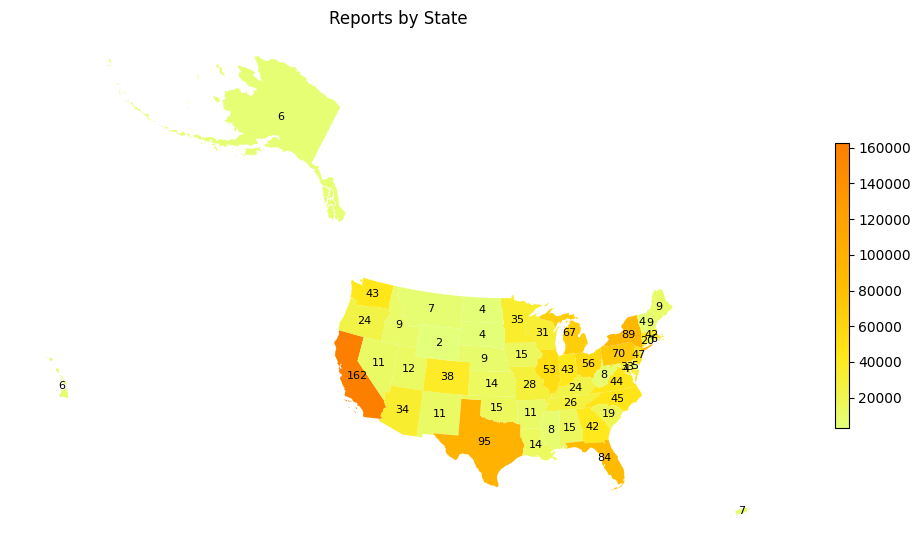

In [6]:
# Query to aggregate state counts
pipeline = [
    {"$group": {"_id": {"$toUpper": "$STATE"}, "count": {"$sum": 1}}}
]

# Execute the aggregation pipeline
result = collection.aggregate(pipeline)

# Convert the result to a pandas DataFrame
state_counts = pd.DataFrame(list(result))

# Load the shapefile for US states
gdf = gpd.read_file('/Users/sep/Documents/HAW/Masterarbeit/cb_2018_us_state_20m/cb_2018_us_state_20m.shp')
gdf = gdf.to_crs('EPSG:5070')  # Albers Equal Area projection

# Merge with geodataframe
merged_gdf = gdf.set_index('STUSPS').join(state_counts.set_index('_id'))

# Plot
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
merged_gdf.plot(column='count', ax=ax, legend=True, cmap='Wistia', legend_kwds={'shrink': 0.5})

# Annotate each state with its count
for x, y, label in zip(merged_gdf.geometry.centroid.x, merged_gdf.geometry.centroid.y, merged_gdf['count']):
    ax.text(x, y, int(label / 1000), ha='center', va='center', fontsize=8, color='black')

plt.title('Reports by State')
ax.set_axis_off()
plt.tight_layout()
plt.savefig('/Users/sep/PycharmProjects/Masterarbeit/Plots/Data_Exploration/Reports_per_State/total_reports_per_state.png')

plt.show()

# Reports per Capita

### Load census data for population per state from 1990 to 2023 for every 10 years

In [22]:
# Define the columns to rename
columns_to_rename = {
    'Unnamed: 0': 'STATE',
    'Unnamed: 1': 'Population 2020',
    'Unnamed: 3': 'Population 2010',
    'Unnamed: 5': 'Population 2000',
    'Unnamed: 7': 'Population 1990',
}

# Load the population data and skip the first 4 rows
census_data = pd.read_excel('/Users/sep/Documents/HAW/Masterarbeit/Census_Population/population-change-data-table.xlsx', skiprows=4)

# Select the columns with odd indices and rename them
selected_columns = ['Unnamed: 0'] + list(census_data.columns[1::2])
census_data = census_data[selected_columns].rename(columns=columns_to_rename)

# Add the STATE_SHORT column by mapping state names to abbreviations
state_to_usps = {
    'Alabama': 'AL', 'Alaska': 'AK', 'American Samoa': 'AS', 'Arizona': 'AZ', 'Arkansas': 'AR', 'California': 'CA',
    'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE', 'Florida': 'FL', 'Georgia': 'GA',
    'Hawaii': 'HI', 'Idaho': 'ID', 'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA',
    'Kansas': 'KS', 'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME', 'Maryland': 'MD',
    'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS', 'Missouri': 'MO',
    'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV', 'New Hampshire': 'NH', 'New Jersey': 'NJ',
    'New Mexico': 'NM', 'New York': 'NY', 'North Carolina': 'NC', 'North Dakota': 'ND', 'Ohio': 'OH',
    'Oklahoma': 'OK', 'Oregon': 'OR', 'Pennsylvania': 'PA', 'Puerto Rico': 'PR', 'Rhode Island': 'RI', 'South Carolina': 'SC',
    'South Dakota': 'SD', 'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT', 'Vermont': 'VT',
    'Virginia': 'VA', 'Washington': 'WA', 'West Virginia': 'WV', 'Wisconsin': 'WI', 'Wyoming': 'WY',
    'District of Columbia': 'DC'
}

census_data = census_data.iloc[:, :5]
census_data['STATE_SHORT'] = census_data['STATE'].map(state_to_usps)
census_data = census_data[['STATE', 'STATE_SHORT'] + [col for col in census_data.columns if col not in ['STATE', 'STATE_SHORT']]]



link to the population data: https://www2.census.gov/programs-surveys/popest/tables/2020-2023/state/totals/NST-EST2023-POP.xlsx

In [23]:
census_data

,STATE,STATE_SHORT,Resident Population 2020 Census,Resident Population 2010 Census,Resident Population 2000 Census,Resident Population 1990 Census
0,Alabama,AL,5024279.0,4779736.0,4447100.0,4040587.0
1,Alaska,AK,733391.0,710231.0,626932.0,550043.0
2,Arizona,AZ,7151502.0,6392017.0,5130632.0,3665228.0
3,Arkansas,AR,3011524.0,2915918.0,2673400.0,2350725.0
4,California,CA,39538223.0,37253956.0,33871648.0,29760021.0
5,Colorado,CO,5773714.0,5029196.0,4301261.0,3294394.0
6,Connecticut,CT,3605944.0,3574097.0,3405565.0,3287116.0
7,Delaware,DE,989948.0,897934.0,783600.0,666168.0
8,District of Columbia,DC,689545.0,601723.0,572059.0,606900.0
9,Florida,FL,21538187.0,18801310.0,15982378.0,12937926.0


### Reports per captita 1990

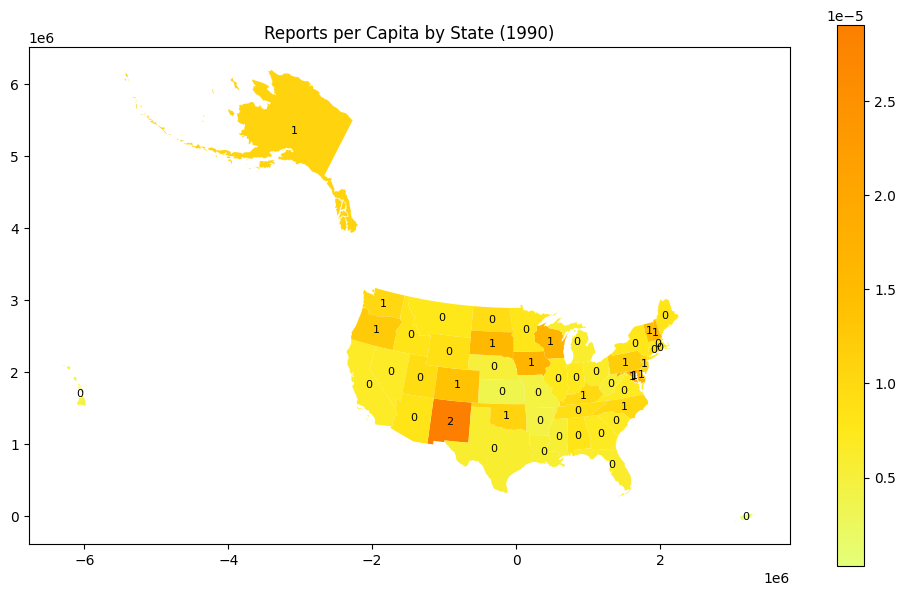

In [21]:
# Year variable
year = 1990  # Change this to switch the year (e.g., 2000)
start_of_year = f"{year}-01-01T00:00:00Z"
end_of_year = f"{year}-12-31T23:59:59Z"

# Aggregation pipeline to filter by date range and project the required data
pipeline = [
    {"$match": {"RECVDATE": {"$gte": pd.to_datetime(start_of_year), "$lte": pd.to_datetime(end_of_year)}}},
    {"$project": {"_id": 0, "STATE": 1}}  # Project only the STATE field
]


data_vaers = pd.DataFrame(list(collection.aggregate(pipeline)))
data_vaers['STATE'] = data_vaers['STATE'].str.upper()

# Load the population data for the specified year
census_data_copy = census_data[['STATE', 'STATE_SHORT', f'Resident Population {year} Census']]

# Count the entries per state in the VAERS data and rename the series for clarity
state_counts = data_vaers['STATE'].value_counts().rename('count')

# Merge the population data with the state counts
census_data_copy.set_index('STATE_SHORT', inplace=True)
state_counts_df = state_counts.to_frame().join(census_data_copy, how='left')
state_counts_df['count'] = state_counts_df['count'].astype('float64')
state_counts_df['entries_per_capita'] = state_counts_df['count'] / state_counts_df[f'Resident Population {year} Census']

# Load the shapefile and set the projection
gdf = gpd.read_file('/Users/sep/Documents/HAW/Masterarbeit/cb_2018_us_state_20m/cb_2018_us_state_20m.shp')
gdf = gdf.to_crs('EPSG:5070')  # Albers Equal Area projection

# Merge the geodataframe with the calculated entries per capita
merged_gdf = gdf.set_index('STUSPS').join(state_counts_df[['entries_per_capita']])

# Plot
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
merged_gdf.plot(column='entries_per_capita', ax=ax, legend=True, cmap='Wistia')
for x, y, label in zip(merged_gdf.geometry.centroid.x, merged_gdf.geometry.centroid.y, merged_gdf['entries_per_capita'] * 100000):
    ax.text(x, y, int(label), ha='center', va='center', fontsize=8, color='black')
plt.title(f'Reports per Capita by State ({year})')
plt.tight_layout()
plt.savefig('/Users/sep/PycharmProjects/Masterarbeit/Plots/Data_Exploration/Reports_per_State/Reports_per_Capita_2000.png')
plt.show()

### Reports per captita 2000

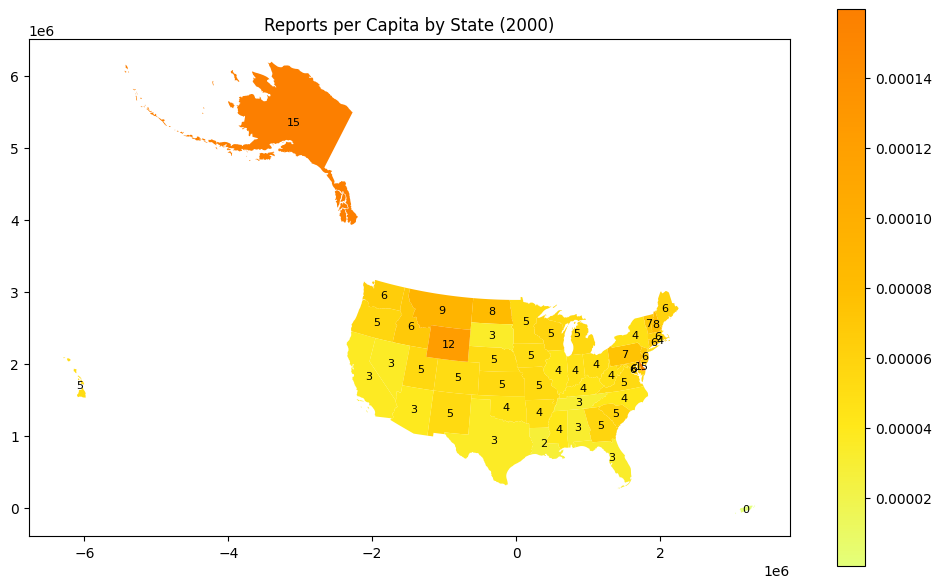

In [20]:
# Year variable
year = 2000  # Change this to switch the year (e.g., 2000)
start_of_year = f"{year}-01-01T00:00:00Z"
end_of_year = f"{year}-12-31T23:59:59Z"

# Aggregation pipeline to filter by date range and project the required data
pipeline = [
    {"$match": {"RECVDATE": {"$gte": pd.to_datetime(start_of_year), "$lte": pd.to_datetime(end_of_year)}}},
    {"$project": {"_id": 0, "STATE": 1}}  # Project only the STATE field
]


data_vaers = pd.DataFrame(list(collection.aggregate(pipeline)))
data_vaers['STATE'] = data_vaers['STATE'].str.upper()

# Load the population data for the specified year
census_data_copy = census_data[['STATE', 'STATE_SHORT', f'Resident Population {year} Census']]

# Count the entries per state in the VAERS data and rename the series for clarity
state_counts = data_vaers['STATE'].value_counts().rename('count')

# Merge the population data with the state counts
census_data_copy.set_index('STATE_SHORT', inplace=True)
state_counts_df = state_counts.to_frame().join(census_data_copy, how='left')
state_counts_df['count'] = state_counts_df['count'].astype('float64')
state_counts_df['entries_per_capita'] = state_counts_df['count'] / state_counts_df[f'Resident Population {year} Census']

# Load the shapefile and set the projection
gdf = gpd.read_file('/Users/sep/Documents/HAW/Masterarbeit/cb_2018_us_state_20m/cb_2018_us_state_20m.shp')
gdf = gdf.to_crs('EPSG:5070')  # Albers Equal Area projection

# Merge the geodataframe with the calculated entries per capita
merged_gdf = gdf.set_index('STUSPS').join(state_counts_df[['entries_per_capita']])

# Plot
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
merged_gdf.plot(column='entries_per_capita', ax=ax, legend=True, cmap='Wistia')
for x, y, label in zip(merged_gdf.geometry.centroid.x, merged_gdf.geometry.centroid.y, merged_gdf['entries_per_capita'] * 100000):
    ax.text(x, y, int(label), ha='center', va='center', fontsize=8, color='black')
plt.title(f'Reports per Capita by State ({year})')
plt.tight_layout()
plt.savefig('/Users/sep/PycharmProjects/Masterarbeit/Plots/Data_Exploration/Reports_per_State/Reports_per_Capita_2000.png')
plt.show()

In [24]:
data_vaers

,STATE
0,WI
1,TX
2,NY
3,OK
4,OH
...,...
2148,OK
2149,NY
2150,IL
2151,TX


### Reports per captita 2010

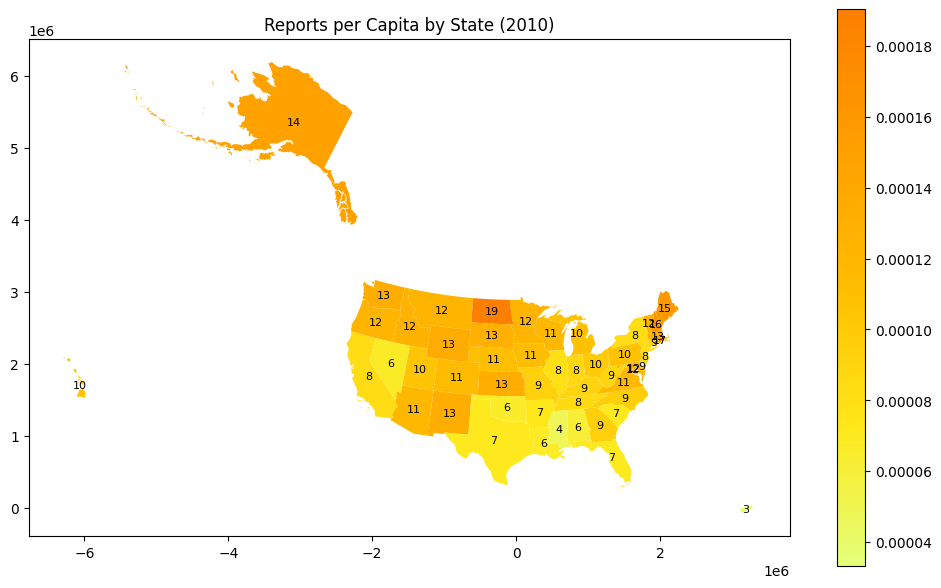

In [25]:
# Year variable
year = 2010  # Change this to switch the year (e.g., 2000)
start_of_year = f"{year}-01-01T00:00:00Z"
end_of_year = f"{year}-12-31T23:59:59Z"

# Aggregation pipeline to filter by date range and project the required data
pipeline = [
    {"$match": {"RECVDATE": {"$gte": pd.to_datetime(start_of_year), "$lte": pd.to_datetime(end_of_year)}}},
    {"$project": {"_id": 0, "STATE": 1}}  # Project only the STATE field
]


data_vaers = pd.DataFrame(list(collection.aggregate(pipeline)))
data_vaers['STATE'] = data_vaers['STATE'].str.upper()

# Load the population data for the specified year
census_data_copy = census_data[['STATE', 'STATE_SHORT', f'Resident Population {year} Census']]

# Count the entries per state in the VAERS data and rename the series for clarity
state_counts = data_vaers['STATE'].value_counts().rename('count')

# Merge the population data with the state counts
census_data_copy.set_index('STATE_SHORT', inplace=True)
state_counts_df = state_counts.to_frame().join(census_data_copy, how='left')
state_counts_df['count'] = state_counts_df['count'].astype('float64')
state_counts_df['entries_per_capita'] = state_counts_df['count'] / state_counts_df[f'Resident Population {year} Census']

# Load the shapefile and set the projection
gdf = gpd.read_file('/Users/sep/Documents/HAW/Masterarbeit/cb_2018_us_state_20m/cb_2018_us_state_20m.shp')
gdf = gdf.to_crs('EPSG:5070')  # Albers Equal Area projection

# Merge the geodataframe with the calculated entries per capita
merged_gdf = gdf.set_index('STUSPS').join(state_counts_df[['entries_per_capita']])

# Plot
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
merged_gdf.plot(column='entries_per_capita', ax=ax, legend=True, cmap='Wistia')
for x, y, label in zip(merged_gdf.geometry.centroid.x, merged_gdf.geometry.centroid.y, merged_gdf['entries_per_capita'] * 100000):
    ax.text(x, y, int(label), ha='center', va='center', fontsize=8, color='black')
plt.title(f'Reports per Capita by State ({year})')
plt.tight_layout()
plt.savefig('/Users/sep/PycharmProjects/Masterarbeit/Plots/Data_Exploration/Reports_per_State/Reports_per_Capita_2000.png')
plt.show()

### Reports per captita 2020

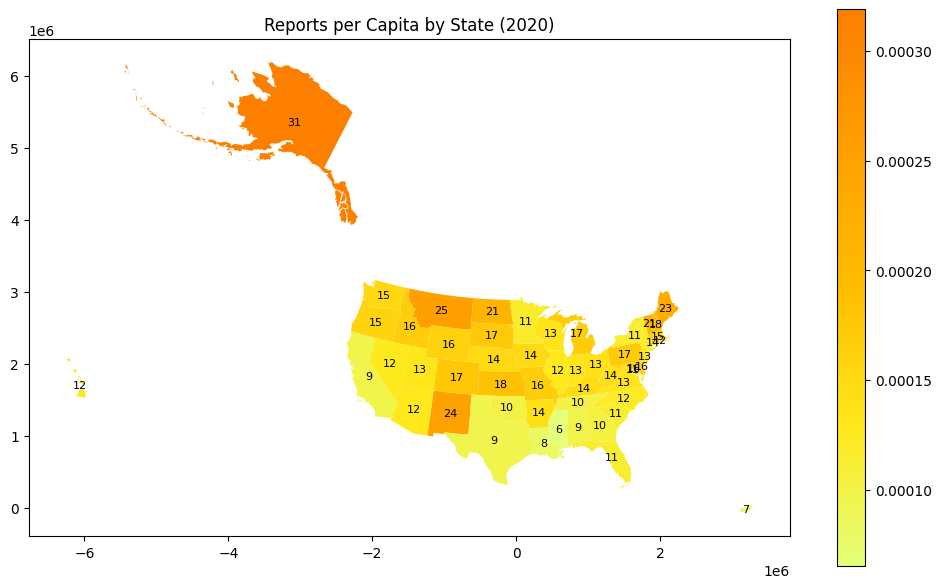

In [26]:
# Year variable
year = 2020  # Change this to switch the year (e.g., 2000)
start_of_year = f"{year}-01-01T00:00:00Z"
end_of_year = f"{year}-12-31T23:59:59Z"

# Aggregation pipeline to filter by date range and project the required data
pipeline = [
    {"$match": {"RECVDATE": {"$gte": pd.to_datetime(start_of_year), "$lte": pd.to_datetime(end_of_year)}}},
    {"$project": {"_id": 0, "STATE": 1}}  # Project only the STATE field
]


data_vaers = pd.DataFrame(list(collection.aggregate(pipeline)))
data_vaers['STATE'] = data_vaers['STATE'].str.upper()

# Load the population data for the specified year
census_data_copy = census_data[['STATE', 'STATE_SHORT', f'Resident Population {year} Census']]

# Count the entries per state in the VAERS data and rename the series for clarity
state_counts = data_vaers['STATE'].value_counts().rename('count')

# Merge the population data with the state counts
census_data_copy.set_index('STATE_SHORT', inplace=True)
state_counts_df = state_counts.to_frame().join(census_data_copy, how='left')
state_counts_df['count'] = state_counts_df['count'].astype('float64')
state_counts_df['entries_per_capita'] = state_counts_df['count'] / state_counts_df[f'Resident Population {year} Census']

# Load the shapefile and set the projection
gdf = gpd.read_file('/Users/sep/Documents/HAW/Masterarbeit/cb_2018_us_state_20m/cb_2018_us_state_20m.shp')
gdf = gdf.to_crs('EPSG:5070')  # Albers Equal Area projection

# Merge the geodataframe with the calculated entries per capita
merged_gdf = gdf.set_index('STUSPS').join(state_counts_df[['entries_per_capita']])

# Plot
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
merged_gdf.plot(column='entries_per_capita', ax=ax, legend=True, cmap='Wistia')
for x, y, label in zip(merged_gdf.geometry.centroid.x, merged_gdf.geometry.centroid.y, merged_gdf['entries_per_capita'] * 100000):
    ax.text(x, y, int(label), ha='center', va='center', fontsize=8, color='black')
plt.title(f'Reports per Capita by State ({year})')
plt.tight_layout()
plt.savefig('/Users/sep/PycharmProjects/Masterarbeit/Plots/Data_Exploration/Reports_per_State/Reports_per_Capita_2000.png')
plt.show()

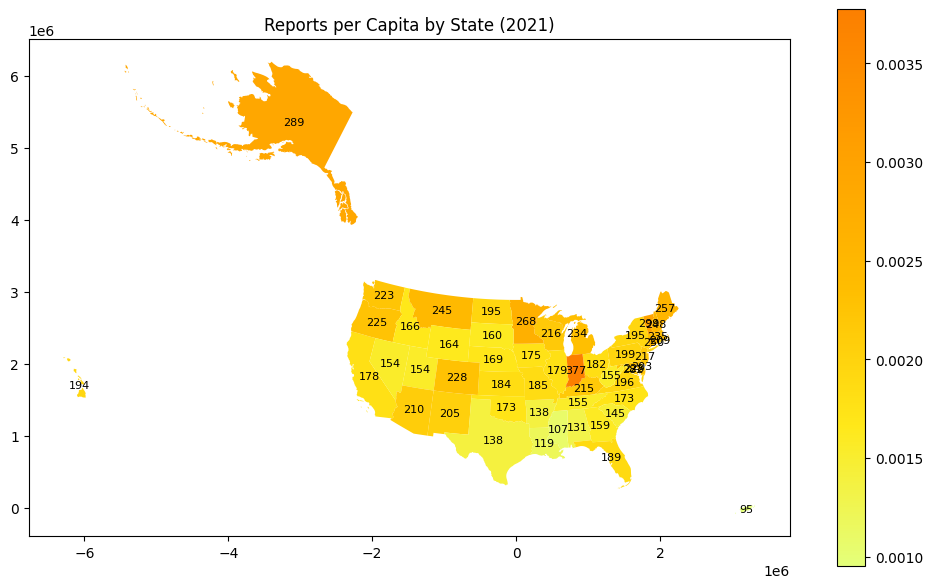

In [29]:
# Year variable for MongoDB query
year = 2021
start_of_year = f"{year}-01-01T00:00:00Z"
end_of_year = f"{year}-12-31T23:59:59Z"

# Aggregation pipeline to filter by date range and project the required data
pipeline = [
    {"$match": {"RECVDATE": {"$gte": pd.to_datetime(start_of_year), "$lte": pd.to_datetime(end_of_year)}}},
    {"$project": {"_id": 0, "STATE": 1}}  # Project only the STATE field
]

# Load the VAERS data from MongoDB
data_vaers = pd.DataFrame(list(collection.aggregate(pipeline)))
data_vaers['STATE'] = data_vaers['STATE'].str.upper()

population_2021 = pd.read_excel('/Users/sep/Documents/HAW/Masterarbeit/Census_Population/NST-EST2023-POP.xlsx', skiprows=8, usecols=[0, 3]).dropna().reset_index(drop=True)
population_2021.columns = ['STATE', 'POPULATION']
population_2021['STATE'] = population_2021['STATE'].str.lstrip('.')
# Apply the mapping to convert state names to abbreviations
population_2021['STATE_SHORT'] = population_2021['STATE'].map(state_to_usps)

# Count the entries per state in the VAERS data and rename the series for clarity
state_counts = data_vaers['STATE'].value_counts().rename('count')

# Merge the population data with the state counts
population_2021.set_index('STATE_SHORT', inplace=True)
state_counts_df = state_counts.to_frame().join(population_2021, how='left')
state_counts_df['count'] = state_counts_df['count'].astype('float64')
state_counts_df['entries_per_capita'] = state_counts_df['count'] / state_counts_df['POPULATION']

# Load the shapefile and set the projection
gdf = gpd.read_file('/Users/sep/Documents/HAW/Masterarbeit/cb_2018_us_state_20m/cb_2018_us_state_20m.shp')
gdf = gdf.to_crs('EPSG:5070')  # Albers Equal Area projection

# Merge the geodataframe with the calculated entries per capita
merged_gdf = gdf.set_index('STUSPS').join(state_counts_df[['entries_per_capita']])

# Plot
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
merged_gdf.plot(column='entries_per_capita', ax=ax, legend=True,cmap='Wistia')

# Annotate each state with the number of entries
for x, y, label in zip(merged_gdf.geometry.centroid.x, merged_gdf.geometry.centroid.y, merged_gdf['entries_per_capita'] * 100000):
    ax.text(x, y, int(label), ha='center', va='center', fontsize=8, color='black')

plt.title('Reports per Capita by State (2021)')
plt.tight_layout()
plt.savefig('/Users/sep/PycharmProjects/Masterarbeit/Plots/Data_Exploration/Reports_per_State/Reports_per_Capita_2021.png')
plt.show()
